# Energy/Wavelength dependent transmission

In [1]:
import openmc
import NCrystal as NC
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = '/Users/shuqixu/Downloads/My_C++/endfb-viii.0-hdf5/cross_sections.xml'

In [2]:
!openmc --version

OpenMC version 0.15.1
Commit hash: 906548db20d4ce3c322e7317992c73b51daeb11d
Copyright (c) 2011-2025 MIT, UChicago Argonne LLC, and contributors
MIT/X license at <https://docs.openmc.org/en/latest/license.html>
Build type:            RelWithDebInfo
Compiler ID:           Clang 18.1.8
MPI enabled:           no
Parallel HDF5 enabled: no
PNG support:           yes
DAGMC support:         no
libMesh support:       no
MCPL support:          no
Coverage testing:      no
Profiling flags:       no
UWUW support:          no


In [3]:
NC.__version__

'4.1.4'

We start defining a function that returns an OpenMC model for a pencil beam incident perpendicular an slab, with two small spheres to tally the incident and transmitted spectra. The function takes as a parameter an OpenMC material to fill the slab.

In [4]:
def create_model_2layers(slab_mat1, slab_mat2, NParticles=1000000, slab1_thickness=1, slab2_thickness=1):
    p1 = openmc.ZPlane(z0=-slab1_thickness/2)
    p2 = openmc.ZPlane(z0=+slab1_thickness/2)
    p3 = openmc.ZPlane(z0=+slab1_thickness/2+slab2_thickness)
    s1 = openmc.Sphere(r=0.1, z0=-(slab1_thickness/2+10))
    s2 = openmc.Sphere(r=0.1, z0=+(slab1_thickness/2+10))
    s3 = openmc.Sphere(r=100, boundary_type='vacuum')
    c1 = openmc.Cell(region=+p1&-p2&-s3, fill=slab_mat1)
    c12 = openmc.Cell(region=+p2&-p3&-s3, fill=slab_mat2)
    c2 = openmc.Cell(region=-s1, fill=None)
    c3 = openmc.Cell(region=-s2, fill=None)
    c4 = openmc.Cell(region=(-p1|+p3)&+s1&+s2&-s3, fill=None)
    u1 = openmc.Universe(cells=[c1, c12, c2, c3, c4])
    geometry = openmc.Geometry(root=u1)
    
    source = openmc.Source()
    source.space  = openmc.stats.Point(xyz=[0,0,-(slab1_thickness/2+20)])
    source.angle  = openmc.stats.Monodirectional(reference_uvw=[0,0,1])
    source.energy = openmc.stats.Uniform(1e-4,1)
    
    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter1 = openmc.CellFilter([c2])
    filter2 = openmc.EnergyFilter(np.geomspace(1e-4, 1, 120))
    tally1.scores = ['flux']
    tally1.name = 'incident spectrum'
    tally1.filters = [filter1, filter2]

    tally2 = openmc.Tally()
    filter3 = openmc.CellFilter([c3])
    tally2.scores = ['flux']
    tally2.name = 'transmitted spectrum'
    tally2.filters = [filter2, filter3]

    tallies = openmc.Tallies([tally1, tally2])
    
    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

We will define a pair of functions to extract the spectra from the statepoint file:

In [5]:
def get_incident_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='incident spectrum')
        df = tally.get_pandas_dataframe()
        phi_g = df['mean'].values
        E_g = df['energy high [eV]'].values
        return E_g, phi_g

def get_transmitted_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='transmitted spectrum')
        df = tally.get_pandas_dataframe()
        phi_g = df['mean'].values
        E_g = df['energy high [eV]'].values
        return E_g, phi_g

In [6]:
def NCTrans(wavelength=None, ncmat='',
            density=None, sample_thickness=None):
    
    E = NC.wl2ekin(wavelength)
    nc   = NC.createScatter("{}".format(ncmat))
    nca  = NC.createAbsorption("{}".format(ncmat))
    info = NC.createInfo("{}".format(ncmat))
    xs  = nc.crossSectionIsotropic(E) + nca.crossSectionIsotropic(E)

    if density == None:
        density = info.density
        
    M = 0 # molar mass per atom
    for i in range(len(info.composition)):
        M += info.composition[i][0] * info.composition[i][1].averageMassAMU()
    factor = density / M * sample_thickness * 0.6022

    print(info.composition, density, M, sample_thickness)
    
    return np.exp(-xs*factor)

# NCrystal Material compositions not overlapped

In [7]:
dx1 = 0.8 # cm
dx2 = 0.025 # cm

ncmat1 = 'Fe_sg229_Iron-alpha.ncmat'
ncmat2 = 'Polyethylene_CH2.ncmat'

m1 = openmc.Material.from_ncrystal(ncmat1)
m2 = openmc.Material.from_ncrystal(ncmat2)

model = create_model_2layers(m1, m2, NParticles=10000000, slab1_thickness=dx1, 
                             slab2_thickness=dx2)
model.export_to_xml()

!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

/Users/shuqixu/opt/miniconda3/envs/ncrystal-v4/lib/python3.13/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [8]:
Ei, phii = get_incident_tally('statepoint.10.h5')
Et, phit = get_transmitted_tally('statepoint.10.h5')

In [9]:
wavelength = np.linspace(0,10,1000)

trans1 = NCTrans(wavelength=wavelength, ncmat=ncmat1, 
                sample_thickness=dx1)
trans2 = NCTrans(wavelength=wavelength, ncmat=ncmat2, 
                sample_thickness=dx2)

[(1.0, Fe=Fe(cohSL=9.45fm cohXS=11.2221barn incXS=0.4barn absXS=2.56barn mass=55.8472amu Z=26))] 7.8654733843566325 55.847211691 0.8
[(0.6666666666666666, H=H(cohSL=-3.739fm cohXS=1.75679barn incXS=80.26barn absXS=0.3326barn mass=1.00798amu Z=1)), (0.3333333333333333, C=C(cohSL=6.646fm cohXS=5.55048barn incXS=0.001barn absXS=0.0035barn mass=12.011amu Z=6))] 0.92 4.675662950230433 0.025


# NCrystal Material compositions overlapped

In [10]:
ncmat1C = 'Fe_sg229_Iron-alpha_C.ncmat'

c = NC.NCMATComposer(ncmat1)
c.write(ncmat1C)
with open(ncmat1C, 'a') as f:
    f.write('@ATOMDB\n')
    f.write('  Fe is 0.9999 Fe 0.0001 C\n')

m1C = openmc.Material.from_ncrystal(ncmat1C)

model = create_model_2layers(m1C, m2, NParticles=10000000, slab1_thickness=dx1, 
                             slab2_thickness=dx2)
model.export_to_xml()

!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

EiC, phiiC = get_incident_tally('statepoint.10.h5')
EtC, phitC = get_transmitted_tally('statepoint.10.h5')

/Users/shuqixu/opt/miniconda3/envs/ncrystal-v4/lib/python3.13/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [11]:
trans1C = NCTrans(wavelength=wavelength, ncmat=ncmat1C, 
                  sample_thickness=dx1)

[(1.0, Mix=Mix{99.99%Fe+0.01%C}(cohSL=9.44972fm cohXS=11.2214barn incXS=0.400059barn absXS=2.55974barn mass=55.8428amu))] 7.864855999431538 55.84282807352122 0.8


# Comparison

Text(0, 0.5, 'Transmission')

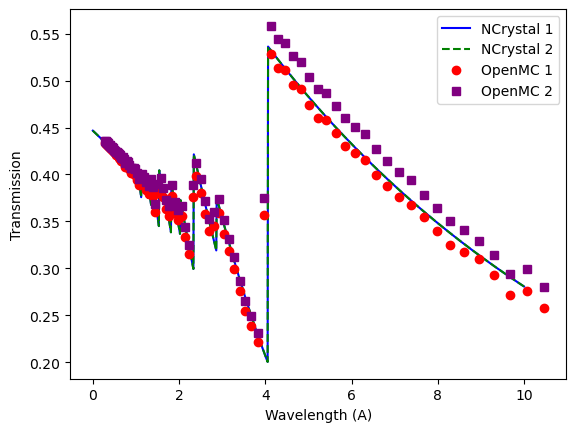

In [12]:
plt.plot(wavelength, trans1 * trans2, label='NCrystal 1', color='blue', linestyle='-')
plt.plot(wavelength, trans1C * trans2, label='NCrystal 2', color='green', linestyle='--')
plt.plot(NC.ekin2wl(Ei[25:]), phit[25:] / phii[25:], 'o', label='OpenMC 1', color='red')
plt.plot(NC.ekin2wl(EiC[25:]), phitC[25:] / phiiC[25:], 's', label='OpenMC 2', color='purple')
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')